In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from new_data import *
import statsmodels.formula.api as sm
import statsmodels.api
import math

conn = sqlite3.connect("C:/Users/j291414/Desktop/market_data.db")

# Prices

In [74]:
# HRC CFR Southeast Asia Index 
sql_hrc = "select * from spot_index where code = 'PLSQ1032 Index'"
df = pd.read_sql_query(sql_hrc, conn)
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df = df[df['date']>='2014-01-02']

# Q235BShanghaiCommercial
fx = get_data('fx', 'fx_daily')
sql_sh = "select * from spot_daily where spotID = 'Q235BShanghaiCommercial'"
sh = pd.read_sql_query(sql_sh, conn)
sh['date'] = pd.to_datetime(sh['date'], format="%Y-%m-%d %H:%M:%S")
sh = sh[['date', 'close']]
sh = divide_fx(sh, fx)

In [75]:
# Merge two DataFrame
compare = sh.merge(df, how='outer', on='date')
# Delete recently daily data

In [77]:
compare.head(10)

,date,close_x,rate,result,code,close_y
0,2014-01-02,3490.0,6.0508,576.783235,NaN,NaN
1,2014-01-03,3490.0,6.0517,576.697457,NaN,NaN
2,2014-01-06,3490.0,6.0525,576.621231,PLSQ1032 Index,555.0
3,2014-01-07,3470.0,6.0512,573.439979,NaN,NaN
4,2014-01-08,3460.0,6.0511,571.796863,NaN,NaN
5,2014-01-09,3460.0,6.0554,571.390825,NaN,NaN
6,2014-01-10,3460.0,6.0521,571.702384,NaN,NaN
7,2014-01-13,3470.0,6.0440,574.123097,PLSQ1032 Index,555.0
8,2014-01-14,3470.0,6.0406,574.446247,NaN,NaN
9,2014-01-15,3470.0,6.0462,573.914194,NaN,NaN


In [78]:
compare = compare[compare['date']<='2017-10-09']
# Average
compare['test'] = np.nan
num = 0
total = 0 
for i in range(len(compare)):
    if math.isnan(compare['close_y'].values[i]):
        total += compare['result'].values[i]
        num += 1
    else:
        if num == 0:
            compare['test'].values[i] = compare['result'].values[i]
            total = 0
            num = 0
        else:
            compare['test'].values[i] = total / float(num)
            total = compare['result'].values[i]
            num = 1
compare = compare[['date', 'close_y', 'test']]
compare = compare.dropna()
compare.columns = ['date', 'close_y', 'result']

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Regression 

                            OLS Regression Results                            
Dep. Variable:                close_y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     8072.
Date:                Thu, 09 Nov 2017   Prob (F-statistic):          2.38e-126
Time:                        17:30:38   Log-Likelihood:                -551.75
No. Observations:                 143   AIC:                             1107.
Df Residuals:                     141   BIC:                             1113.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.2690      4.408      3.464      0.0

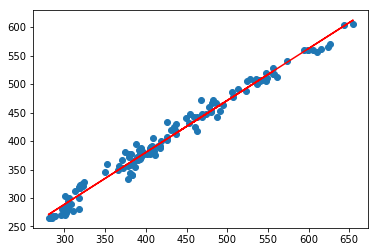

In [79]:
# delete recently daily values
compare = compare[(compare['date']<='2017-10-09')]
compare = compare[(compare['date']>='2015-01-01')]

result = sm.ols('close_y ~ result', compare).fit()
print result.summary()
k = result.params[1]
b = result.params[0]
plt.plot(compare['result'], compare['close_y'], 'o')
plt.plot(compare['result'], k*compare['result']+b, 'r')
plt.show()

# Error


count    1.430000e+02
mean    -1.991507e-13
std      1.150674e+01
min     -2.662666e+01
25%     -6.757743e+00
50%     -1.104001e+00
75%      7.416131e+00
max      3.057130e+01
Name: spread, dtype: float64


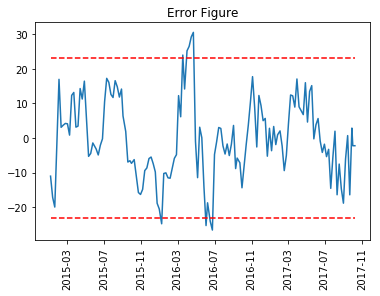

In [80]:
compare['spread'] = compare['close_y'] - (k*compare['result']+b)
std = compare['spread'].describe()['std']
plt.plot(compare['date'], compare['spread'])
plt.plot(compare['date'], 2*std*np.ones(len(compare['date'])), 'r--')
plt.plot(compare['date'], -2*std*np.ones(len(compare['date'])), 'r--')
plt.title('Error Figure')
plt.xticks(rotation='vertical')
print
print compare['spread'].describe()
plt.show()

In [81]:
spread_lag = compare.spread.shift(1)
spread_lag.values[0] = spread_lag.values[1]
spread_ret = compare.spread - spread_lag
spread_ret.values[0] = spread_ret.values[1]
spread_lag2 = statsmodels.api.add_constant(spread_lag)
 
model = statsmodels.api.OLS(spread_ret,spread_lag2)
res = model.fit()
 
 
halflife = round(-np.log(2) / res.params[1],0)
 
if halflife <= 0:
    halflife = 1

print 
print  'Halflife = ',halflife
print


Halflife =  3.0

